In [1]:
from openpyxl import load_workbook

from astropy.time import Time
from datetime import timedelta, datetime
from lsst_efd_client import EfdClient

import matplotlib.pyplot as plt
import scipy.io
import numpy as np
import pandas as pd

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

### Multiple positions for +x, see
https://jira.lsstcorp.org/secure/Tests.jspa#/testPlayer/testExecution/LVV-E1008

In [2]:
start = Time('2020-03-04T17:49:00') #this is UTC
end = Time('2020-03-04T18:12:00') 

client = EfdClient('summit_efd')
csc_index = 1

In [3]:
df = await client.select_time_series('lsst.sal.MTM2.mirrorPositionMeasured', '*', 
                                     (start-timedelta(seconds=37)).tai, (end-timedelta(seconds=37)).tai, csc_index)
df.head()

,piston,private_host,private_kafkaStamp,private_origin,private_rcvStamp,private_revCode,private_seqNum,private_sndStamp,thetaZPosition,xPosition,xTilt,yPosition,yTilt
2020-03-04 17:49:00.011000+00:00,0.416174,1,1.583344e+09,125069,1.583344e+09,c3c6bc7d,1956559,1.583344e+09,2.120036e-10,0.306845,-1.563860e-08,-0.175872,-1.846662e-08
2020-03-04 17:49:00.059000+00:00,0.416174,1,1.583344e+09,125069,1.583344e+09,c3c6bc7d,1956568,1.583344e+09,2.120036e-10,0.306845,-1.563860e-08,-0.175872,-1.846662e-08
2020-03-04 17:49:00.109000+00:00,0.416174,1,1.583344e+09,125069,1.583344e+09,c3c6bc7d,1956577,1.583344e+09,2.120036e-10,0.306845,-1.563860e-08,-0.175872,-1.846662e-08
2020-03-04 17:49:00.160000+00:00,0.416174,1,1.583344e+09,125069,1.583344e+09,c3c6bc7d,1956586,1.583344e+09,2.120036e-10,0.306845,-1.563860e-08,-0.175872,-1.846662e-08
2020-03-04 17:49:00.211000+00:00,0.416174,1,1.583344e+09,125069,1.583344e+09,c3c6bc7d,1956595,1.583344e+09,2.120036e-10,0.306845,-1.563860e-08,-0.175872,-1.846662e-08


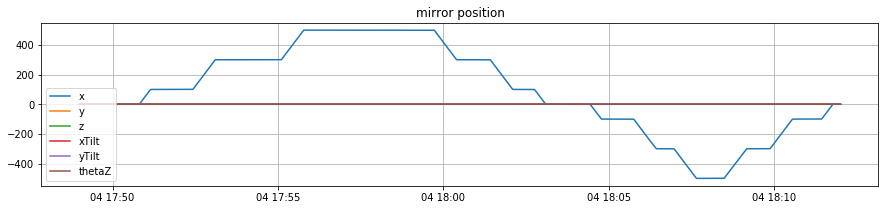

In [5]:
fig, ax = plt.subplots(figsize=(15,3))
plt.plot(pd.to_datetime(df.private_sndStamp, unit='s'), df.xPosition, label='x')
plt.plot(pd.to_datetime(df.private_sndStamp, unit='s'), df.yPosition, label='y')
plt.plot(pd.to_datetime(df.private_sndStamp, unit='s'), df.piston, label='z')
plt.plot(pd.to_datetime(df.private_sndStamp, unit='s'), df.xTilt, label='xTilt')
plt.plot(pd.to_datetime(df.private_sndStamp, unit='s'), df.yTilt, label='yTilt')
plt.plot(pd.to_datetime(df.private_sndStamp, unit='s'), df.thetaZPosition, label = 'thetaZ')
plt.title('mirror position')
plt.legend(loc='lower left')
plt.grid();

In [30]:
myMean = np.zeros((6, 12))
myStd = np.zeros((6, 12))
def fillMeanStd(df, idx, myMean, myStd, icol):
    myMean[0,icol] = np.mean(df.xPosition[idx])
    myMean[1,icol] = np.mean(df.yPosition[idx])
    myMean[2,icol] = np.mean(df.piston[idx])
    myMean[3,icol] = np.mean(df.xTilt[idx])
    myMean[4,icol] = np.mean(df.yTilt[idx])
    myMean[5,icol] = np.mean(df.thetaZPosition[idx])
    myStd[0,icol] = np.std(df.xPosition[idx])
    myStd[1,icol] = np.std(df.yPosition[idx])
    myStd[2,icol] = np.std(df.piston[idx])
    myStd[3,icol] = np.std(df.xTilt[idx])
    myStd[4,icol] = np.std(df.yTilt[idx])
    myStd[5,icol] = np.std(df.thetaZPosition[idx])
    return myMean, myStd

In [74]:
xx = np.array(df.xPosition)
idx0 = np.arange(32*20) #32 seconds
for i in range(12):
    if i==0:
        aa = 0
    elif i==1:
        aa = np.argmax(xx>99)+200
    elif i==2:
        aa = np.argmax(xx>299)+200
    elif i==3:
        aa = np.argmax(xx>499)+200
    elif i==4:
        aa = len(xx) - np.argmax(xx[::-1]>299)-37*20
    elif i==5:
        aa = len(xx) - np.argmax(xx[::-1]>99)-37*20
    elif i==6:
        aa = np.argmax(xx<-1)-37*20
    elif i==7:
        aa = np.argmax(xx<-99)+200
    elif i==8:
        aa = np.argmax(xx<-299)+200
        print(aa)
    elif i==9:
        aa = np.argmax(xx<-499)+200
    elif i==10:
        aa = len(xx) - np.argmax(xx[::-1]<-299)-37*20
    elif i==11:
        aa = len(xx) - np.argmax(xx[::-1]<-99)-37*20
    idxi = np.arange(aa, aa+20*20) #we only doing 20 seconds duration, because i=8, the 2nd -300um was short
    myMean, myStd = fillMeanStd(df, idxi, myMean, myStd, i)

21110


### stability

In [76]:
np.max(myStd)

0.0001737325232866784

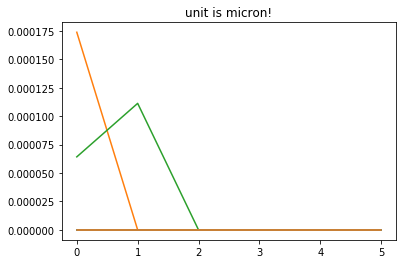

In [79]:
plt.plot(myStd)
plt.title('unit is micron!');

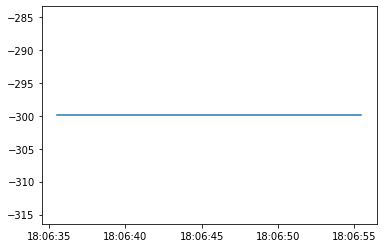

In [73]:
plt.plot(pd.to_datetime(df.private_sndStamp[21110:21110+20*20], unit='s'), df.xPosition[21110:21110+20*20], label='x')

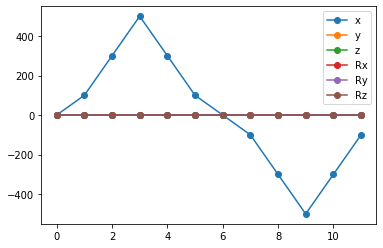

In [88]:
plt.plot(myMean.transpose(),'-o')
plt.legend(['x','y','z','Rx', 'Ry', 'Rz']);

### Repeatability? (hysterisis?)

-12.3805412619447
-28.205530016521152
-27.41247547724015
-59.87582869539665
-28.39710376065341
-24.631307193582558
-5.524239904843853
-20.090248617634643
-18.401650504517875
-51.492863234091146
-20.361261322250357


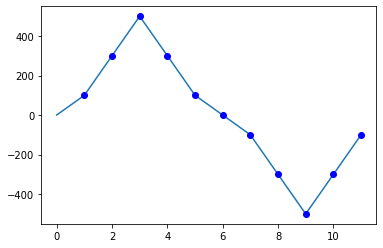

In [95]:
myTrue = np.array([0, 100, 300, 500, 300, 100, 0, -100, -300, -500, -300, -100])
plt.plot(myMean[0,:])
for i in range(1,12):
    aa = (myMean[0,i]-myTrue[i])*(myTrue[i]-myTrue[i-1])
    if aa>0:
        bb = 'ro'
    elif aa<0:
        bb = 'bo'
    else:
        bb = 'go'
    plt.plot(i, myMean[0,i],bb)

In [94]:
myMean[0,:]

array([ 3.06845244e-01,  9.98761946e+01,  2.99858972e+02,  4.99862938e+02,
        3.00299379e+02,  1.00141986e+02,  2.46313072e-01, -9.99447576e+01,
       -2.99899549e+02, -4.99907992e+02, -3.00257464e+02, -1.00101806e+02])

### So we always stopped ahead of set points
Difference in x is up to ~0.5 micron

In [96]:
myMean[0,0] - myMean[0,6]

0.0605321723317806

In [97]:
myMean[0,1] - myMean[0,5]

-0.26579093142271404

In [98]:
myMean[0,2] - myMean[0,4]

-0.440406793559589

In [99]:
myMean[0,7] - myMean[0,11]

0.1570487056596903

In [100]:
myMean[0,8] - myMean[0,10]

0.35791555925862895